# setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
#         )
#     except RuntimeError as e:
#         print(e)

2025-05-20 17:22:31.023100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747761751.149727 1367832 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747761751.182502 1367832 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747761751.442839 1367832 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747761751.442859 1367832 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747761751.442862 1367832 computation_placer.cc:177] computation placer alr

# HP tuning

## pre-processing

In [3]:
case_name = 'rainshaft_dt300_sedflux'
base_path = '/pscratch/sd/a/arthurhu/BOSS_PPE/summary_ncs/'
filename = case_name + '.nc'

param_all_idx = np.arange(39)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))

param_train = ef.get_params(base_path, filename, param_interest_idx)

In [4]:
nppe, npar = param_train['vals'].shape

In [5]:
dataset = nc.Dataset(base_path + filename, mode='r')

In [6]:
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [7]:
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [8]:
ppe_var_presence = ppe_asinh = ppe_all = np.empty((nppe,0), dtype=np.float32)
ncases = tgt_raw_vals[0].shape[0]
tgt_var_presence = tgt_asinh = tgt_all = np.empty((ncases,0), dtype=np.float32)

for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)
    ppe_var_presence = np.concatenate((ppe_var_presence, ppe_raw_val_reshaped > eff0s[idx]/100), axis=1)
    ppe_asinh_reshaped = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
    ppe_asinh = np.concatenate((ppe_asinh, ppe_asinh_reshaped), axis=1)
    tgt_var_presence = np.concatenate((tgt_var_presence, tgt_raw_val_reshaped > eff0s[idx]/100), axis=1)
    tgt_asinh_reshaped = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
    tgt_asinh = np.concatenate((tgt_asinh, tgt_asinh_reshaped), axis=1)


In [9]:
np.sum(~np.isfinite(param_train['vals']))

np.int64(0)

In [10]:
param_train['vals'][1,:]

masked_array(data=[ 7.39277113e-05, -9.08195210e+00,  2.42879620e+01,
                   -1.68155760e-01,  2.57169697e-02,  1.47334263e-01,
                   -2.38416623e-03,  5.72572291e-01,  1.89379886e-01,
                    3.46292406e-01,  5.46184361e-01,  5.41824043e-01],
             mask=False,
       fill_value=1e+20)

In [11]:
from sklearn import preprocessing
import sklearn.model_selection as mod_sec

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

standscale = preprocessing.StandardScaler().fit(ppe_asinh)
ppe_all = standscale.transform(ppe_asinh)
tgt_all = standscale.transform(tgt_asinh)

In [12]:
x_train, x_val, y_train_wpresence, y_val_wpresence = mod_sec.train_test_split(x_all, ppe_var_presence, test_size=0.2, random_state=1)
_, _, y_train, y_val = mod_sec.train_test_split(x_all, ppe_all, test_size=0.2, random_state=1)

y_train = np.nan_to_num(y_train, nan=-1001)
y_val = np.nan_to_num(y_val, nan=-1001)

(array([5.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 9.000e+00, 7.200e+01, 6.900e+01, 1.110e+02,
        2.640e+02, 2.920e+02, 6.940e+02, 1.249e+03, 1.616e+03, 1.271e+03,
        6.260e+02, 3.520e+02, 3.060e+02, 3.080e+02, 2.670e+02, 2.720e+02,
        2.620e+02, 2.460e+02, 2.490e+02, 2.630e+02, 2.850e+02, 2.044e+03,
        2.390e+02, 2.350e+02, 2.530e+02, 2.670e+02, 3.210e+02, 3.210e+02,
        3.050e+02, 2.670e+02, 2.750e+02, 2.710e+02, 2.460e+02, 2.970e+02,
        3.630e+02, 3.700e+02, 2.610e+02, 2.140e+02, 2.330e+02, 2.520e+02,
        2.730e+02, 2.050e+02, 1.980e+02, 2.170e+02, 2.390e+02, 1.960e+02,
        1.620e+02, 1.640e+02, 1.500e+02, 1.770e+02, 1.290e+02, 1.390e+02,
        1.440e+02, 1.450e+02, 1.310e+02, 1.300e+02, 1.240e+02, 1.020e+02,
        1.220e+02, 1.320e+02, 1.370e+0

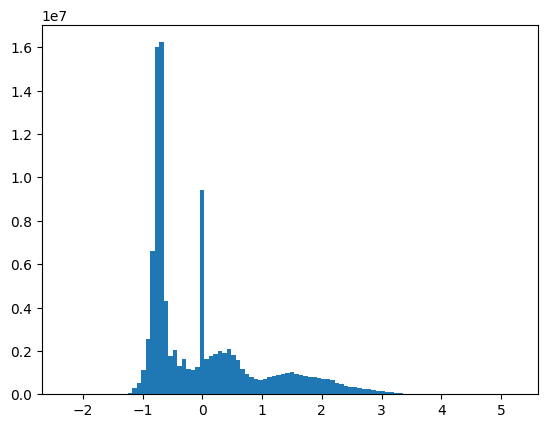

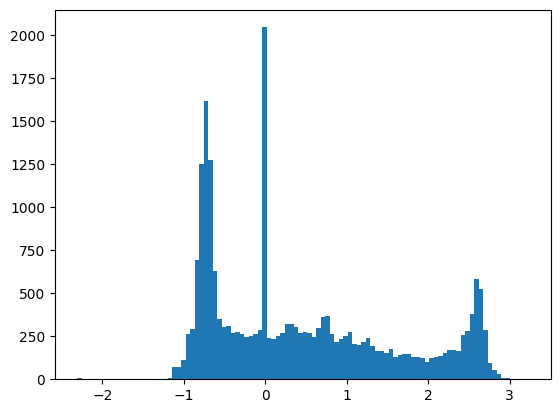

In [13]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 0
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
# plt.hist(y_all[:,5:65].flatten(), bins=100)
# plt.figure()
# plt.hist(tgt_all[:,5:65].flatten(), bins=100)

plt.hist(ppe_all[:,a+4:a+2580].flatten(), bins=100)
plt.figure()
plt.hist(tgt_all[:,a+4:a+2580].flatten(), bins=100)

In [14]:
np.mean(tgt_all[0,a+4:a+3604])

np.float64(-0.6259873082601212)

## multi-output model

In [15]:
proj_name = 'try6_rainshaft_sedflux_M3069'
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_model(hp, npar, nobs),
    objective="val_loss",
    max_trials=100,
    directory='/pscratch/sd/a/arthurhu/BOSS_PPE/hp_tuning_withclass/multi-output',
    project_name=proj_name,
)


stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    x_train,
    {'presence': y_train_wpresence, 'water': y_train},
    epochs=50,
    validation_data=(x_val, {'presence': y_val_wpresence, 'water': y_val}),
    callbacks=([stop_early])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)



Trial 100 Complete [00h 01m 55s]
val_loss: 1.6166032552719116

Best val_loss So Far: 0.2707463502883911
Total elapsed time: 03h 18m 53s


In [16]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 224)       │      2,912 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     28,800 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     33,024 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence (Dense)    │ (None, 2069)      │    531,733 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water (Dense)       │ (None, 2069)      │    531,733 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,128,202 (4.30 MB)

 Trainable params: 1,128,202 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_presence_accuracy', mode='max', patience=2000)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, {'presence': y_train_wpresence, 'water': y_train}))
                 .shuffle(buffer_size=len(x_train))
                 .cache()
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((x_val, {'presence': y_val_wpresence, 'water': y_val}))
               .cache()
               .batch(32)
               .prefetch(tf.data.AUTOTUNE))

history = best_model.fit(
    train_dataset,
    epochs=10000,
    verbose=0,
    validation_data=val_dataset,
    callbacks=[TqdmCallback(verbose=1), stop_early]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
plt.figure()
plt.plot(history.epoch, history.history['presence_accuracy'], label='Training')
plt.plot(history.epoch, history.history['val_presence_accuracy'], label='Validation')
plt.ylabel('Water Presence Accuracy')
plt.legend()

plt.figure()
plt.plot(history.epoch, history.history['water_loss'], label='Training')
plt.plot(history.epoch, history.history['val_water_loss'], label='Validation')
plt.ylabel('Water Content Loss')
plt.legend()

In [ ]:
# save model:
best_model.save('/pscratch/sd/a/arthurhu/BOSS_PPE/models/multioutput_' + proj_name + '.keras')

## validation

In [ ]:
# best_model = tf.keras.models.load_model('models/multioutput_try28_condcoll_fullmom_nopartition_asinh.keras', compile=False)
plt.plot(best_model(x_val)[1][:, 0])
# cc_model(x_val)[1]

In [ ]:
plt.plot(y_val[:,0])

In [ ]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy())
# y_pred = model(x_val)
plt.plot(y_pred[:,0])

In [ ]:
standscale.inverse_transform(y_train)

In [ ]:
np.mean(y_pred[:, 0]), np.mean(standscale.inverse_transform(y_train)[:, 0])

In [ ]:
y_pred.shape

In [ ]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy())
# y_pred = standscale.inverse_transform(model(x_val).numpy())
# y_pred = np.exp(standscale.inverse_transform(model(x_val).numpy()))
y_val_lin = standscale.inverse_transform(y_val)
# y_train_lin = np.exp(standscale.inverse_transform(y_train))

fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(1,4)
for i in range(len(eff0)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')
    plt.scatter(y_val_lin[:,i], y_pred[:,i], alpha=0.05,c='k')
    # plt.scatter(ppe_sim_valid['vals'][:,i], y_pred[:,i],alpha=0.2,c='k')
    # plt.scatter(y_val[:,i], y_pred[:,i],alpha=0.2,c='k')
    plt.title(ppe_sim_train['var_names'][i])
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    # ax.set_xscale('log')
    # ax.set_yscale('log')
# fig.tight_layout()
# plt.savefig(plot_dir + proj_name + '.png')